# Two-outlier Groups (Section 4.7)

We next see that, if there are two groups of outliers that lie on opposing sides of a bulk of data, both AMIP and Additive One-Exact can suffer Type 1 failures. This example was inspired by the two-data point example in Section 4.5.

In this example, the overall slope (across all data points) has a different sign than the slope in just the red data or just the black data. To create the illustration in \cref{}, we draw 1,000 red crosses with $x_n \sim \mathcal{N}(0,0.25)$ iid, $y_n = -x_n + \epsilon_n$, and $\epsilon_n \sim \mathcal{N}(0,1)$ iid. We draw distinct groups of black dots. The group in the bottom left with $x_n \sim \mathcal{N}(-15,0.25)$ iid and the group in the top right with $x_n \sim \mathcal{N}(15,0.25)$ iid. Both groups of black dots has $y_n = x_n + \epsilon_n$, and $\epsilon_n \sim \mathcal{N}(0,1)$ iid. The OLS-estimated slope on the full dataset is 0.81. Dropping the black dots ($0.99\%$ of the data) yields a slope of -1.00, a sign change.

When asked to find the worst-case $0.99\%$ (i.e., 10 data points) of the dataset to drop, both AMIP and Additive One-Exact choose the 10 black dots, indicating a success in correctly identifying the Most Influential Set \cref{}. However, both methods underestimate the impact of dropping the Most Influential Set, resulting in a failure to detect the sign change (a Type-1 failure). Upon removing the flagged data points and re-running the data analysis, in both cases, the additive methods detect the sign change. Both greedy methods flag the 10 black-dot points as the ones to drop, so neither suffers a failure. Note, if the two groups of black points lie sufficiently far away from the red-cross points, this will result in a Type 2 failure of the additive algorithms.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import linear_regression
from linear_regression import LinearRegression
import algorithms
import gurobipy as gp
from gurobipy import GRB
import scipy.linalg
import itertools

In [17]:
# set random seed for reproducibility.
np.random.seed(6)

### Data Generation.

In [18]:
total_observations = 1010
num_observations_pop_1 = 6 # A (small fraction)
num_observations_pop_2 = 4 # B (small fraction)
num_observations_pop_3 = total_observations - (num_observations_pop_1+num_observations_pop_2)

# Generate X values.
mean_pop_1 = np.array([15])
mean_pop_2 = np.array([-15])
mean_pop_3 = np.array([0])
vars_pop_1 = np.array([[0.25]])
vars_pop_2 = np.array([[0.25]])
vars_pop_3 = np.array([[0.25]])

x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x3 = np.random.multivariate_normal(mean_pop_3, vars_pop_3, num_observations_pop_3)
x = np.append(x1, x2, axis=0)
x = np.append(x, x3, axis=0)
x1_0 = [pt[0] for pt in x1]
x2_0 = [pt[0] for pt in x2]
x3_0 = [pt[0] for pt in x3]

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:num_observations_pop_1]
x2 = x[num_observations_pop_1:num_observations_pop_1+num_observations_pop_2]
x3 = x[num_observations_pop_1+num_observations_pop_2:]

# Generate Y values.
epsilon = np.random.normal(0, 1, num_observations_pop_1)
slope1 = 1
intercept1 = 0

y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope1*x1_0[i] + intercept1 + epsilon[i])

slope2 = 1
intercept2 = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope2*x2_0[i] + intercept2 + epsilon[i])

epsilon3 = np.random.normal(0, 1, num_observations_pop_3)
slope3 = -1
intercept3 = 0

y3 = []
for i in range(num_observations_pop_3):
    y3.append(slope3*x3_0[i] + intercept3 + epsilon3[i])

y = np.concatenate([y1, y2, y3], axis=0)
y

array([13.97038593, 15.43461257, 15.20501615, ...,  0.48896233,
        0.2582278 ,  0.46313534])

### Cross Leverage Computations.

In [4]:
# Compute the inverse Covariance Matrix.
A = np.linalg.inv(x.T @ x)
# Compute the Hat Matrix.
H = x @ A @ x.T
# Compute the Least-Squares Estimator.
Betahat = np.linalg.inv(x.T @ x) @ x.T @ y

In [15]:
# compute DFBETAs for the black dots.
dfbeta0 = 1/ (1 - H[0, 0]) * A @ x[0] * (y[0] - x[0].T @ Betahat)
dfbeta1 = 1/ (1 - H[1, 1]) * A @ x[1] * (y[1] - x[1].T @ Betahat)
print(f"DFBETA for the 1st black dot: {dfbeta0[1]}")
print(f"DFBETA for the 2nd black dot: {dfbeta1[1]}")
# compute residuals for the black dots.
residual0 = y[0] - x[0].T @ Betahat
residual1 = y[1] - x[1].T @ Betahat


DFBETA for the 1st black dot: 0.026487902962234813
DFBETA for the 2nd black dot: 0.02097143495703042


In [16]:
black_dots_cross_leverage = x[0].T @ np.linalg.inv(x.T @ x) @ x[1]
print(f"Cross leverage score for the 2 black dots: {round(black_dots_cross_leverage, 4)}")
mean_cross_leverage = np.mean([x[i-1].T @ np.linalg.inv(x.T @ x) @ x[i] for i in range(3, len(x))])
print(f"Mean cross leverage score for the 1000 red crosses: {round(mean_cross_leverage, 4)}")

Cross leverage score for the 2 black dots: 0.09
Mean cross leverage score for the 1000 red crosses: 0.0014


In [1242]:
# compute the fit of the first black dot.
y1_pred_full = x1[0].T @ lr.beta
print(f'The fit of the bottom left black dot is {y1_pred_full}.')
# compute the fit of the first black dot with the second black dot removed.
y1_pred_noTR = x1[0].T @ lr_noTR.beta
print(f'The fit of the bottom left black dot with the top right black dot removed is {y1_pred_noTR}.')
# compute the difference in the fits.
y1_pred_diff = y1_pred_noTR - y1_pred_full
print(f'The impact of dropping the top right black dot on the fit of the bottom left black dot is {y1_pred_diff}.')

# compute the fit of the second black dot.
y2_pred_full = x1[1].T @ lr.beta
print(f'The fit of the top right black dot is {y2_pred_full}.')
# compute the fit of the second black dot with the first black dot removed.
y2_pred_noBL = x1[1].T @ lr_noBL.beta
print(f'The fit of the top right black dot with the bottom left black dot removed is {y2_pred_noBL}.')
# compute the difference in the fits.
y2_pred_diff = y2_pred_noBL - y2_pred_full
print(f'The impact of dropping the bottom left black dot on the fit of the top right black dot is {y2_pred_diff}.')

The fit of the bottom left black dot is -34.251043722504335.
The fit of the bottom left black dot with the top right black dot removed is -22.856436597273458.
The impact of dropping the top right black dot on the fit of the bottom left black dot is 11.394607125230877.
The fit of the top right black dot is 34.3580643692659.
The fit of the top right black dot with the bottom left black dot removed is 22.891417027918013.
The impact of dropping the bottom left black dot on the fit of the top right black dot is -11.466647341347883.


In [1243]:
min_distance = np.inf
for i in range(len(x2)):
    distance = np.sqrt((x1[0][1] - x2[i][1])**2 + (y1[0] - y2[i])**2)
    if distance < min_distance:
        min_distance = distance
print(f'The minimum distance between the lower left black dot and the closest red cross is {min_distance}.')

min_distance = np.inf
for i in range(len(x2)):
    distance = np.sqrt((x1[1][1] - x2[i][1])**2 + (y1[1] - y2[i])**2)
    if distance < min_distance:
        min_distance = distance
print(f'The minimum distance between the upper right black dot and the closest red cross is {min_distance}.')

print(f'The two black dots are around equidistant from the red crosses.')

The minimum distance between the lower left black dot and the closest red cross is [68.23850034].
The minimum distance between the upper right black dot and the closest red cross is [68.55925797].
The two black dots are around equidistant from the red crosses.


In [1247]:
print(f'The ratio of residuals is {residual0 / residual1} while the cross-leverage is {H[0,1]}.')

The ratio of residuals is -1.0068419055856026 while the cross-leverage is -0.42054803135618374.


### Model Fitting.

Fit the data using OLS regression.

In [19]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
lr_inliers = LinearRegression(x=x3.T, y=y3)
lr_inliers.fit()
lr_outliers1 = LinearRegression(x=x1.T, y=y1)
lr_outliers1.fit()
lr_outliers2 = LinearRegression(x=x2.T, y=y2)
lr_outliers2.fit()
print(
    f"Estimated beta for full data: {round(lr.beta[1], 4)} \n"
    f"Estimated beta for red crosses: {round(lr_inliers.beta[1], 4)} \n"
    f"Estimated beta for pop 1: {round(lr_outliers1.beta[1], 4)} \n"
    f"Estimated beta for pop 2: {round(lr_outliers2.beta[1], 4)} \n"
)

Estimated beta for full data: 0.8137 
Estimated beta for red crosses: -0.8953 
Estimated beta for pop 1: 0.9185 
Estimated beta for pop 2: 0.8442 



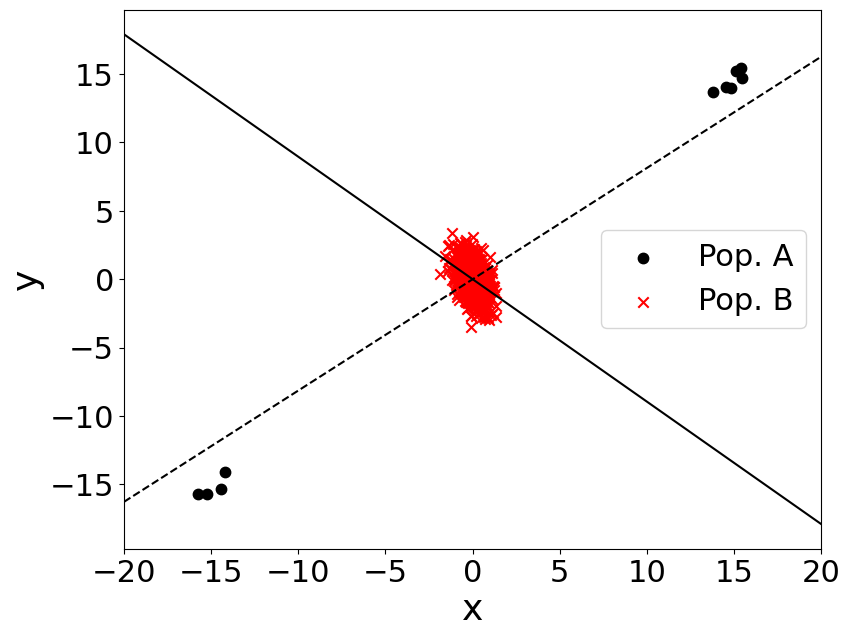

In [21]:
plt.figure(figsize=(9, 7))

plt.scatter(x1[:, 1], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2[:, 1], y2, marker='o', color='black', s=56)
plt.scatter(x3[:, 1], y3, marker='x', color='r', label='Pop. B', s=56)

x_values = np.linspace(-20, 20, 100)
y_values_full = lr.beta[1] * x_values
y_value_red_crosses = lr_inliers.beta[1] * x_values
plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

# set range of y-axis
# plt.ylim(-130, 130)
plt.xlim(-20, 20)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

plt.legend(fontsize=22)
# plt.savefig('two_outlier_groups_example.pdf')
plt.show()

### Net Approx. Algorithm.

In [22]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy.linalg
import itertools

'''
For fixed lambda, compute maximum weight of any weight vector w
that has lambda in OLS(X,y,w)
'''
def solve_fixed_lambda(X,XR,lam):
    n = X.shape[0]
    d = X.shape[1]
    c = -np.ones((n))
    A_eq = np.zeros((d,n))
    b_eq = np.zeros((d))
    for i in range(d):
        A_eq[i] = (X.T)[i] * (XR@lam)
    m = gp.Model("net-model")
    m.Params.OutputFlag = 0
    w = m.addMVar(shape=n,vtype=GRB.CONTINUOUS,name="w",lb=0,ub=1)
    m.setObjective(c @ w, GRB.MINIMIZE)
    m.addConstr(A_eq @ w == b_eq)
    m.optimize()
    return w.X

'''
NET UPPER BOUND

Input:
- X: n x d (covariate matrix)
- y: n (response vector)
- trials: integer

Output:
- Net upper bound on Stability(X,y)
'''
def net_algorithm(X,y,trials):
    n = X.shape[0]
    d = X.shape[1]
    XR = np.zeros((d,n))
    for i in range(d-1):
        XR[i] = (X.T)[i+1]
    XR[d-1] = y
    XR = XR.T
    assert(np.linalg.matrix_rank(XR)==d)
    U,s,Vh = scipy.linalg.svd(XR, full_matrices=False)
    A = Vh.T @ np.diag(1.0/s) @ np.eye(d)
    wstar = np.zeros((n))
    for i in range(trials):
        v = np.random.multivariate_normal(np.zeros((d)),np.eye(d))
        v = v / np.linalg.norm(v)
        lam = A@v
        w = solve_fixed_lambda(X,XR,lam)
        if sum(w) > sum(wstar):
            wstar = w
    return n-sum(wstar), wstar

In [21]:
n_sumwstar, wstar = net_algorithm(x[:,1:],y,1000)

Set parameter Username
Set parameter LicenseID to value 2617160
Academic license - for non-commercial use only - expires 2026-02-01


In [22]:
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indice of wstar that are non-one.
mis_inds = np.where(wstar != 1)[0]
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 9.02224403101502


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Gurobi [FH23].

In [8]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

Set parameter Username
Set parameter LicenseID to value 2617160
Academic license - for non-commercial use only - expires 2026-02-01
set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 2020 rows, 1012 columns and 2020 nonzeros
Model fingerprint: 0x2ae91a16
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [4e-04, 2e+01]
  QLMatrix range   [3e-05, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2020 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 20

In [9]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1013 columns and 1 nonzeros
Model fingerprint: 0x1f6650cb
Model has 3 quadratic constraints
Variable types: 3 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-07, 2e+02]
  QLMatrix range   [3e-05, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

User MIP start produced solution with objective 1001 (0.00s)
Loaded user MIP start with objective 1001

Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 6062 rows, 10103 columns, 23230 nonzeros
Presolved model has 6060 SOS constraint(s)
Variable types: 6063 

In [10]:
weights_array = np.array([w.X for w in weights])

In [11]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(weights_array == 0)[0]
indices_to_remove

array([0, 1, 2, 3, 5, 6, 7, 8, 9])

### Gurobi (no warm-start)

In [12]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1013 columns and 1 nonzeros
Model fingerprint: 0x62964d81
Model has 3 quadratic constraints
Variable types: 3 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-07, 2e+02]
  QLMatrix range   [3e-05, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 6062 rows, 10103 columns, 23230 nonzeros
Presolved model has 6060 SOS constraint(s)
Variable types: 6063 continuous, 4040 integer (4040 binary)

Root relaxation: o

In [13]:
weights_array = np.array([w.X for w in weights])

# select the indices of the points with weight 0.
indices_to_remove = np.where(weights_array == 0)[0]
indices_to_remove

array([   0,    1,    2, ..., 1007, 1008, 1009])

In [15]:
len(indices_to_remove)

1010

#### Refit after Removing Flagged Points.

In [14]:
Gurobi_inds= indices_to_remove
new_x= np.delete(x, Gurobi_inds, axis=0)
new_y= np.delete(y, Gurobi_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(0, 2)
(0,)


In [ ]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by NetApprox: {modified_lr_na.beta[1]}"
)

### Running Additive and Greedy algorithms.

In [23]:
def compute_scores(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression model.
    '''
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # sort scores according to indices.
    sorted_scores = if_scores[if_inds]
    sorted_newton_scores = newton_scores[newton_inds]

    # compute residuals and leverages.
    residuals = lr.residual()
    leverages = lr.leverage_scores()

    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x1, 'y': y, 
                            'residual': residuals, 'leverage': leverages, 
                            'IF': if_scores, '1Exact': newton_scores,
                            'sorted_IF_indices': if_inds, 'sorted_1Exact_indices': newton_inds,
                            'sorted_IF_scores': sorted_scores, 'sorted_1Exact_scores': sorted_newton_scores})
    return orig_df

#### Additive Algorithms.

In [27]:
OS_outliers_df = compute_scores(x, y, lr)

The additive approximations fail in the type 1 sense but succeed in the type 2 sense because the indices of black dots are exactly the indices for the first 10 points to remove.

In [25]:
OS_outliers_df[:10]

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,14.844108,13.970386,1.850785,0.090765,-0.011213,-0.012332,6,6,-0.021312,-0.023330
1,15.364502,15.434613,2.891572,0.097181,-0.018133,-0.020085,9,9,-0.020859,-0.023073
2,15.108910,15.205016,2.869948,0.094002,-0.017698,-0.019534,7,7,-0.018755,-0.020905
3,14.550454,14.078561,2.197904,0.087242,-0.013052,-0.014299,1,1,-0.018133,-0.020085
4,13.756610,13.655301,2.420589,0.078071,-0.013588,-0.014739,2,2,-0.017698,-0.019534
5,15.456626,14.675933,2.057931,0.098340,-0.012983,-0.014399,8,8,-0.015025,-0.016393
6,-14.436468,-15.310190,-3.604419,0.086501,-0.021312,-0.023330,4,4,-0.013588,-0.014739
7,-15.757047,-15.686936,-2.906620,0.102830,-0.018755,-0.020905,3,5,-0.013052,-0.014399
8,-14.180354,-14.084249,-2.586875,0.083499,-0.015025,-0.016393,5,3,-0.012983,-0.014299
9,-15.214947,-15.686840,-3.347627,0.095954,-0.020859,-0.023073,0,0,-0.011213,-0.012332


In [26]:
print(f'The AMIP approximation for the change induced by dropping the worst-case subset is {round(sum(OS_outliers_df["sorted_IF_scores"][:num_observations_pop_1]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset is {round(sum(OS_outliers_df["sorted_1Exact_scores"][:num_observations_pop_1]), 4)}.')
print(f'The true change induced by dropping the worst-case subset is {round((lr_inliers.beta[1] - lr.beta[1]), 4)}.')

print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(OS_outliers_df["sorted_IF_scores"][:num_observations_pop_1]), 4)}.')
print(f'The Add-1Exact approximation of the refit is {round(lr.beta[1] + sum(OS_outliers_df["sorted_1Exact_scores"][:num_observations_pop_1]), 4)}.')
print(f'The true refit is {round((lr_inliers.beta[1]), 4)}.')

The AMIP approximation for the change induced by dropping the worst-case subset is -0.1118.
The Add-1Exact for the change induced by dropping the worst-case subset is -0.1233.
The true change induced by dropping the worst-case subset is -1.709.
The AMIP approximation of the refit is 0.7019.
The Add-1Exact approximation of the refit is 0.6904.
The true refit is -0.8953.


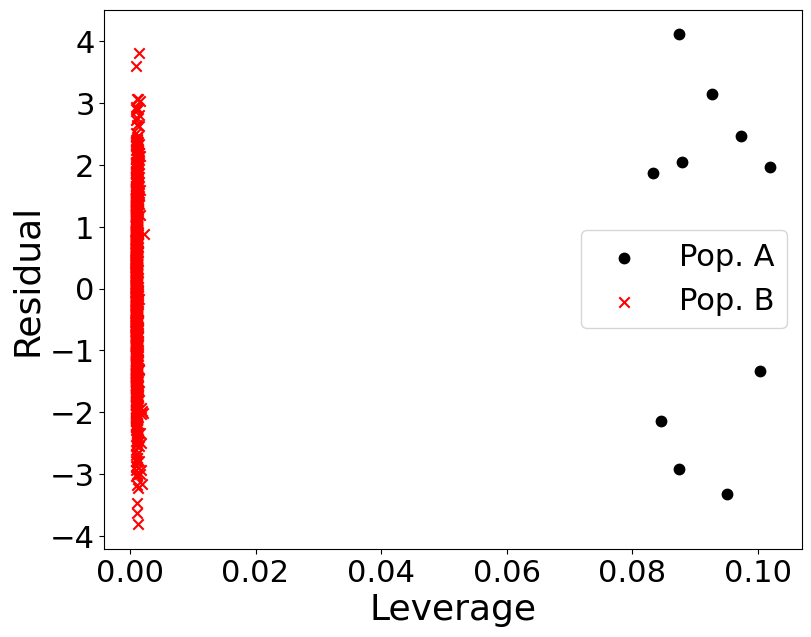

In [11]:
plt.figure(figsize=(9, 7))

plt.scatter(OS_outliers_df['leverage'][:10], OS_outliers_df['residual'][:10], marker='o', color='black', label='Pop. A', s=56)
plt.scatter(OS_outliers_df['leverage'][10:], OS_outliers_df['residual'][10:], marker='x', color='r', label='Pop. B', s=56)

plt.xlabel('Leverage', fontsize=26) 
plt.ylabel('Residual', fontsize=26)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

plt.legend(fontsize=22)
# plt.savefig('two_outlier_groups_levresid.pdf', bbox_inches='tight')
plt.show()

#### The Leverage Algorithm.

In [12]:
# sort leverage scores in descending order.
np.argsort(OS_outliers_df['leverage'][:10])

0    5
1    7
2    0
3    9
4    2
5    1
6    8
7    3
8    6
9    4
Name: leverage, dtype: int64

#### Type-2 Failure Mode Check.

We can check for type 2 errors by removing the data points flagged by AMIP/Add-1Exact.
In order to induce a type 2 error for the two-outlier groups example, move the two outlier groups far away in distance from the red-cross points.

In [13]:
# Refit after Removing Flagged Points (AMIP and 1Exact flagged the same points.)
AMIP_inds= [8,3,7,6,4,641,574,301,114,554]
new_x_amip= np.delete(x, AMIP_inds, axis=0)
new_y_amip= np.delete(y, AMIP_inds, axis=0)
print(new_x_amip.shape)
print(new_y_amip.shape)

(1000, 2)
(1000,)


In [14]:
# Refit after removing the points specified by AMIP and Additive 1sN (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_amip = LinearRegression(x=new_x_amip.T, y=new_y_amip)
modified_lr_amip.fit()
print(
    f"Estimated beta1 after removing subset specified by AMIP: {modified_lr_amip.beta[1]}"
)

Estimated beta1 with full dataset: 0.8215669900278497
Estimated beta1 after removing subset specified by AMIP: 0.6914425757561031


#### Greedy Algorithms.

In [15]:
def create_orig_df(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression object.
    '''
    # compute IF/1Exact scores.
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # residuals
    residuals = lr.residual()
    # leverages
    leverages = lr.leverage_scores()
    # x's
    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': if_scores, 'newton': newton_scores})
    
    print(orig_df[:5])
    return orig_df, if_inds, if_scores, newton_inds, newton_scores

def create_plot(orig_df, num_observations_pop_1):
    '''
    orig_df: output from the helper function above.
    '''

    # Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("Point to Drop: ", sorted_if_df.index[0])
    
    # sorted_if_df: the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    sorted_if_df['sorted_idx'] = index
    
    # Plot points dropped
    plt.figure(figsize=(9, 7))
    plt.scatter(orig_df[:num_observations_pop_1]['x1'], orig_df[:num_observations_pop_1]['y'], marker='x', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[num_observations_pop_1:]['x1'], orig_df[num_observations_pop_1:]['y'], marker='x', color='r', label='Pop. B') # pop B

    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

def Run_Greedy(num_observations_pop_1, x, y, orig_if_inds, orig_newton_inds, lr, num_iter, method='IF'):
    '''
    num_observations_pop_1: number of black dot points.
    x: design matrix.
    y: response vector.
    orig_inds: indices sorted by the first round.
    lr: linear regression object.
    method: 'IF' or '1Exact'.
    num_iter: number of iterations.
    '''
    ctr = 0
    prev_beta = lr.beta[1] # initialize to the original beta estimate.
    dropped_order = []
    exact_changes_beta = []
    beta_estimates_greedy = []
    if_inds = orig_if_inds
    newton_inds = orig_newton_inds

    for _ in range(num_iter):
        print(f'interation {ctr}')

        if method == 'IF':
            inds = if_inds
        else:
            inds = newton_inds
        
        # 1. drop the datapoint with the most negative influence:
        index_to_remove = inds[0]
        print("index to remove", index_to_remove)

        dropped_order.append(index_to_remove)

        new_x = np.concatenate((x[:index_to_remove], x[index_to_remove + 1:]))
        new_y = np.concatenate((y[:index_to_remove], y[index_to_remove + 1:]))

        x = new_x
        y = new_y

        # 2. calculate the exact perturbation (ie. refit the lr to get the change in the coefficient.)
        lr = LinearRegression(x=x.T, y=y)
        lr.fit()
        print(f'fitted beta1: {lr.beta[1]}')

        # 3. compute scores and create plot.
        orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(x, y, lr)
        create_plot(orig_df, num_observations_pop_1)

        # 4. record: the exact change in beta.
        beta_change = lr.beta[1] - prev_beta
        exact_changes_beta.append(beta_change)
        prev_beta = lr.beta[1]
        beta_estimates_greedy.append(lr.beta[1])

        # counter
        ctr += 1

    return dropped_order, exact_changes_beta, beta_estimates_greedy

In [16]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(orig_x, orig_y, lr)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

          x1          y  residual  leverage  influence    newton
0  14.781998  16.230084  4.117737  0.087422  -0.024172 -0.026488
1  15.217752  15.618784  3.148435  0.092614  -0.019029 -0.020971
2  14.821695  14.201416  2.056454  0.087889  -0.012105 -0.013271
3  15.595639  15.256038  2.475229  0.097239  -0.015333 -0.016985
4  15.970392  15.055524  1.966831  0.101938  -0.012478 -0.013894
inds [0 8 1 9 3 4 7 2 5 6]
newton_inds [0 8 1 9 3 4 7 2 5 6]


Both greedy algorithms succeed.

interation 0
index to remove 0
fitted beta1: 0.7950790870656151
          x1          y  residual  leverage  influence    newton
0  15.217752  15.618784  3.554443  0.101486  -0.023540 -0.026199
1  14.821695  14.201416  2.451972  0.096308  -0.015815 -0.017501
2  15.595639  15.256038  2.891247  0.106554  -0.019625 -0.021966
3  15.970392  15.055524  2.392776  0.111702  -0.016633 -0.018725
4  14.428695  13.696567  2.259589  0.091306  -0.014187 -0.015612
Point to Drop:  7


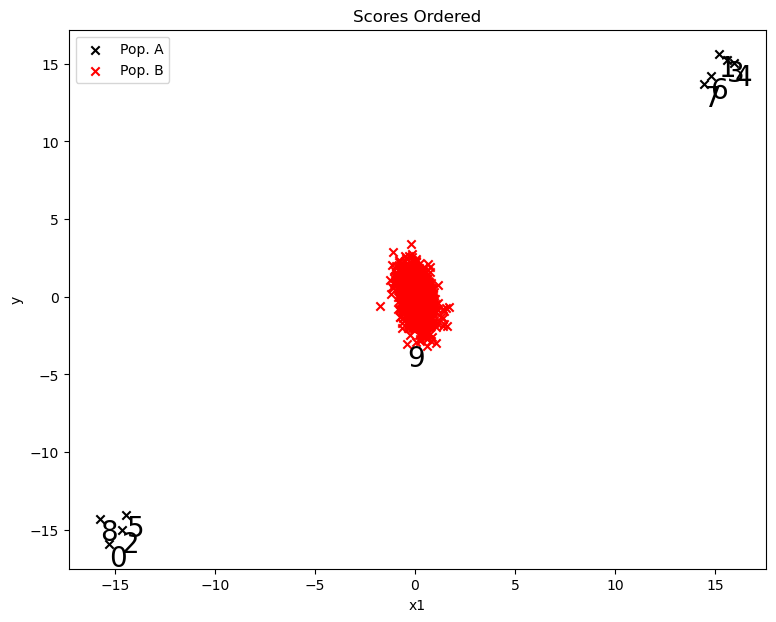

interation 1
index to remove 7
fitted beta1: 0.7672517254767601
          x1          y  residual  leverage  influence    newton
0  15.217752  15.618784  3.972580  0.112796  -0.029300 -0.033025
1  14.821695  14.201416  2.859087  0.107030  -0.020536 -0.022998
2  15.595639  15.256038  3.319899  0.118439  -0.025096 -0.028468
3  15.970392  15.055524  2.831856  0.124174  -0.021923 -0.025032
4  14.428695  13.696567  2.655767  0.101459  -0.018568 -0.020665
Point to Drop:  0


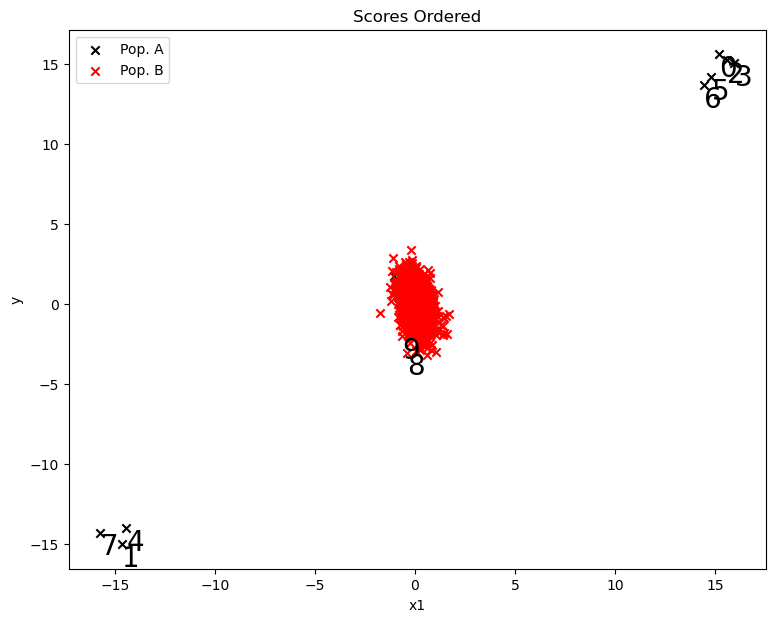

interation 2
index to remove 0
fitted beta1: 0.7342268763484829
          x1          y  residual  leverage  influence    newton
0  14.821695  14.201416  3.351066  0.120637  -0.027131 -0.030853
1  15.595639  15.256038  3.837437  0.133497  -0.032696 -0.037733
2  15.970392  15.055524  3.361770  0.139960  -0.029333 -0.034107
3  14.428695  13.696567  3.134767  0.114358  -0.024705 -0.027895
4 -15.727224 -14.279138 -2.699650  0.137263  -0.023326 -0.027037
Point to Drop:  6


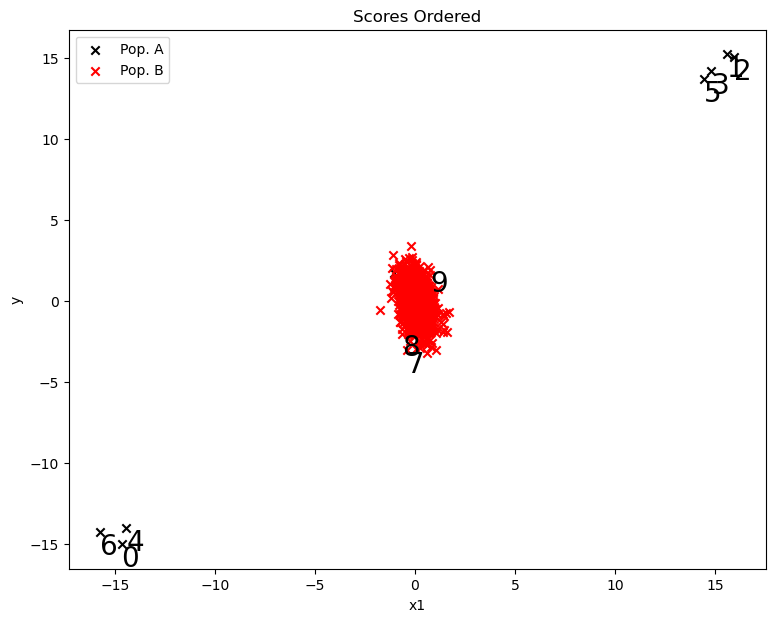

interation 3
index to remove 6
fitted beta1: 0.6957342738016455
          x1          y  residual  leverage  influence    newton
0  14.821695  14.201416  3.915158  0.136479  -0.035930 -0.041609
1  15.595639  15.256038  4.431320  0.151057  -0.042799 -0.050415
2  15.970392  15.055524  3.970078  0.158383  -0.039269 -0.046659
3  14.428695  13.696567  3.683732  0.129362  -0.032907 -0.037796
4 -15.727224 -14.279138 -3.311466  0.155899  -0.032495 -0.038497
Point to Drop:  1


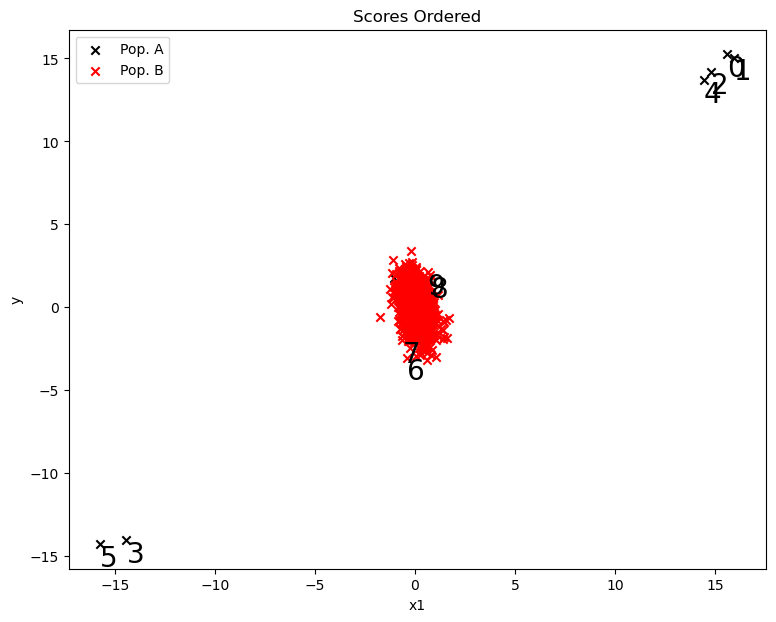

interation 4
index to remove 1
fitted beta1: 0.6453195422903394
          x1          y  residual  leverage  influence    newton
0  14.821695  14.201416  4.664626  0.160763  -0.050428 -0.060088
1  15.970392  15.055524  4.777458  0.186565  -0.055662 -0.068429
2  14.428695  13.696567  4.413388  0.152379  -0.046443 -0.054793
3 -15.727224 -14.279138 -4.102113  0.182924  -0.047323 -0.057917
4 -14.423922 -14.022890 -4.686911  0.154097  -0.049601 -0.058636
Point to Drop:  1


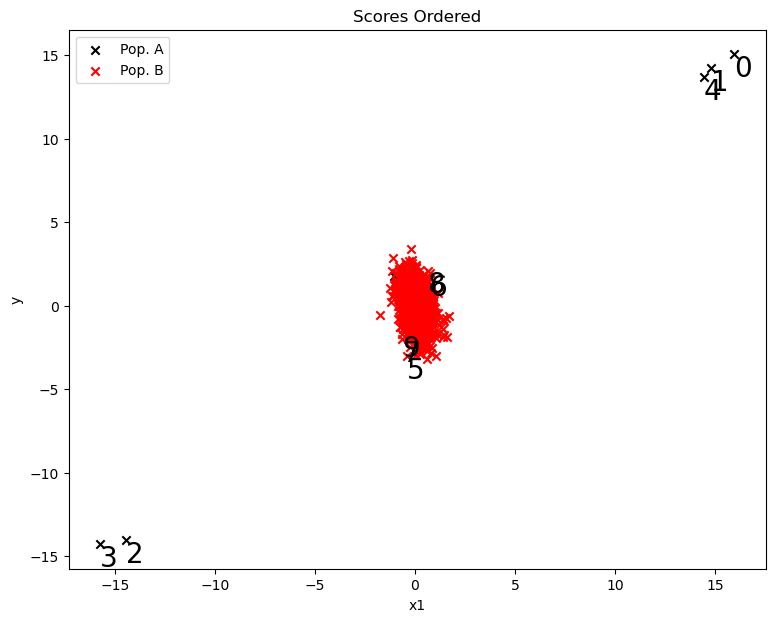

interation 5
index to remove 1
fitted beta1: 0.5768907414382448
          x1          y  residual  leverage  influence    newton
0  14.821695  14.201416  5.681753  0.197634  -0.075518 -0.094119
1  14.428695  13.696567  5.403622  0.187325  -0.069913 -0.086029
2 -15.727224 -14.279138 -5.175412  0.223980  -0.073251 -0.094394
3 -14.423922 -14.022890 -5.671027  0.188613  -0.073626 -0.090741
4   0.169590   0.199019  0.132020  0.001014  -0.000017 -0.000017
Point to Drop:  0


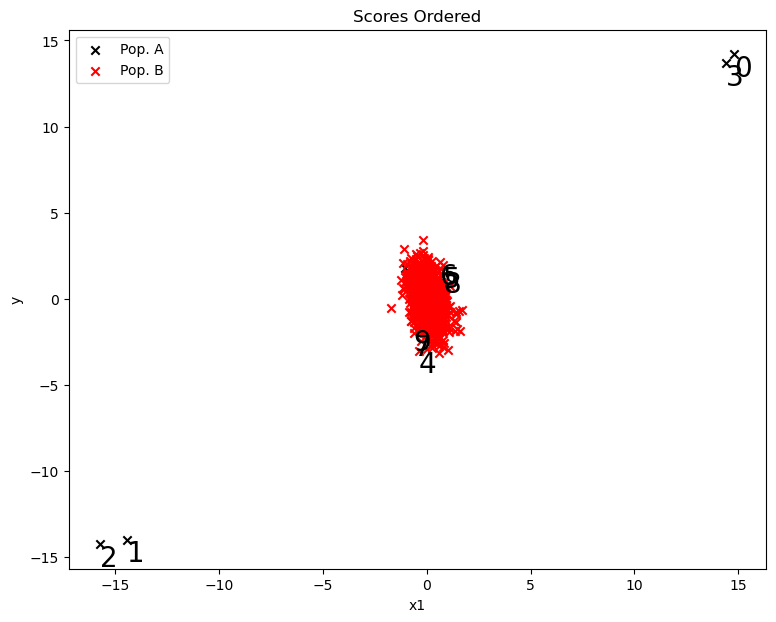

interation 6
index to remove 0
fitted beta1: 0.4827719288772539
          x1          y  residual  leverage  influence    newton
0  14.428695  13.696567  6.766124  0.233466  -0.109107 -0.142338
1 -15.727224 -14.279138 -6.651149  0.278108  -0.117099 -0.162212
2 -14.423922 -14.022890 -7.024099  0.234117  -0.113426 -0.148098
3   0.169590   0.199019  0.152473  0.001025  -0.000027 -0.000027
4  -1.034554   1.751093  2.285874  0.002223   0.002677  0.002683
Point to Drop:  1


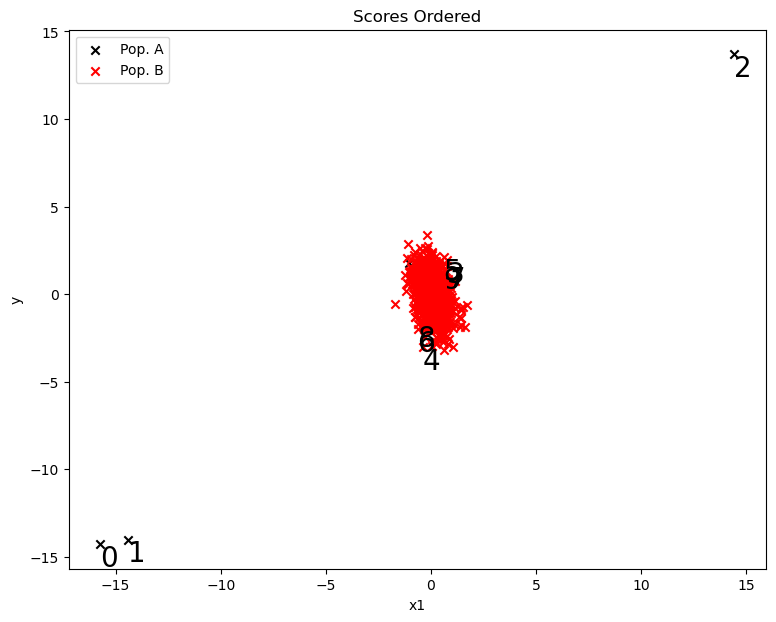

interation 7
index to remove 1
fitted beta1: 0.32056000186623446
          x1          y  residual  leverage  influence    newton
0  14.428695  13.696567  9.095422  0.322004  -0.202748 -0.299041
1 -14.423922 -14.022890 -9.375040  0.324308  -0.209730 -0.310393
2   0.169590   0.199019  0.168773  0.001029  -0.000037 -0.000037
3  -1.034554   1.751093  2.106848  0.002746   0.003466  0.003475
4   0.261011  -0.124045 -0.183597  0.001082   0.000066  0.000066
Point to Drop:  1


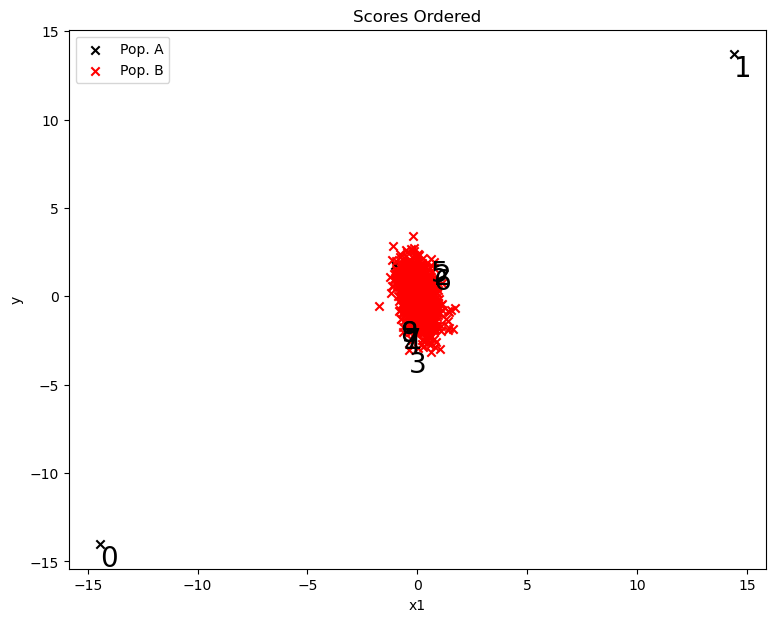

interation 8
index to remove 1
fitted beta1: 0.010167157520508866
          x1          y   residual  leverage  influence    newton
0  14.428695  13.696567  13.551392  0.474650  -0.446170 -0.849282
1   0.169590   0.199019   0.198819  0.001036  -0.000058 -0.000058
2  -1.034554   1.751093   1.763136  0.003654   0.004347  0.004362
3   0.261011  -0.124045  -0.125175  0.001108   0.000063  0.000063
4   0.159975   0.138001   0.137898  0.001031  -0.000037 -0.000037
Point to Drop:  0


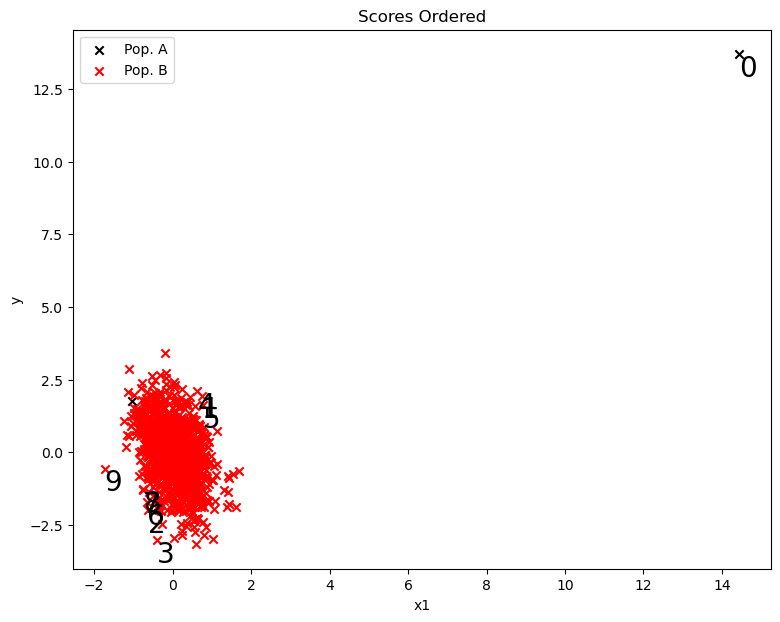

interation 9
index to remove 0
fitted beta1: -0.8391146230167484
         x1         y  residual  leverage  influence    newton
0  0.169590  0.199019  0.332424  0.001087  -0.000205 -0.000205
1 -1.034554  1.751093  0.874083  0.005916   0.004043  0.004067
2  0.261011 -0.124045  0.086073  0.001236  -0.000087 -0.000087
3  0.159975  0.138001  0.263338  0.001076  -0.000151 -0.000151
4  0.718344  0.374682  0.968554  0.003073  -0.002909 -0.002918
Point to Drop:  174


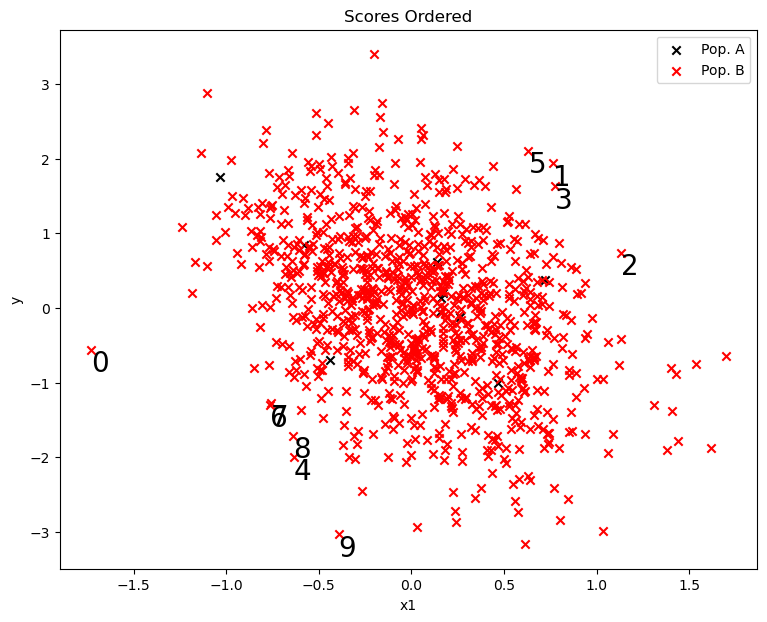

dropped order: 
 [0, 7, 0, 6, 1, 1, 0, 1, 1, 0]
exact (greedy) beta estimates: 
 [0.7950790870656151, 0.7672517254767601, 0.7342268763484829, 0.6957342738016455, 0.6453195422903394, 0.5768907414382448, 0.4827719288772539, 0.32056000186623446, 0.010167157520508866, -0.8391146230167484]


In [17]:
num_observations_pop_1=10
num_iter=10
# Run Greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = Run_Greedy(num_observations_pop_1, orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, num_iter, method='IF')

print("dropped order: \n", dropped_order[:num_observations_pop_1])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:num_observations_pop_1])

### Cross-leverage Algorithm.

In [18]:
alphaN = 10
hat_matrix = x @ np.linalg.inv(x.T @ x) @ x.T
unique_indices, cross_leverages = lr.hat_matrix_algorithm(hat_matrix,alphaN)

off-diagonal value included for (3, 4)
off-diagonal value included for (6, 8)
off-diagonal value included for (1, 4)
off-diagonal value included for (2, 4)
off-diagonal value included for (0, 4)
off-diagonal value included for (6, 9)
off-diagonal value included for (4, 5)
off-diagonal value included for (6, 7)


In [19]:
print(f"Unique indices: {unique_indices}")
print(f"Cross-leverages: {cross_leverages}")

Unique indices: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Cross-leverages: [0.10193761239459899, 0.10033907910132435, 0.09956014963926056, 0.09769487917047306, 0.09716279539626094, 0.09465017621756458, 0.09439833179697878, 0.09366074359148757, 0.09215694995275532, 0.09213653816990211]
